# ANN-SoLo profiling

In [1]:
%matplotlib inline
import io
import os
import pstats

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

In [2]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.3)    # single-column figure

In [3]:
prof_dir = '../data/processed/iprg2012/profiling'

In [4]:
def extract_cum_time(stats, stream, func):
    stats.print_stats(func)
    stream.seek(0)
    return float(stream.read().strip().split('\n')[-1].split()[3])

def process_prof(filename):
    stream = io.StringIO()
    stats = pstats.Stats(filename, stream=stream)

    mode = 'Brute-force' if 'bf' in filename else 'ANN-SoLo'
    precursor_tol_mass = 20 if 'std' in filename else 300
    precursor_tol_mode = 'ppm' if 'std' in filename else 'Da'
    prof = {'mode': mode,
            'precursor_tol_mass': precursor_tol_mass,
            'precursor_tol_mode': precursor_tol_mode,
            'libio': extract_cum_time(stats, stream, 'get_spectrum'),
            'rank': extract_cum_time(stats, stream, 'get_best_match')}
    total = extract_cum_time(stats, stream, 'builtins.exec')
    prof['select'] = extract_cum_time(stats, stream, '_filter_library_candidates') - prof['libio']
    prof['other'] = total - prof['select'] - prof['rank'] - prof['libio']
    
    return prof

In [5]:
profiling = []
for filename in ['bf_std.prof', 'bf_oms_shifted.prof', 'ann_oms_shifted.prof']:
    profiling.append(process_prof(os.path.join(prof_dir, filename)))

profiling = pd.DataFrame(profiling)

In [6]:
profiling_bar = profiling[['select', 'rank', 'libio', 'other']]
# convert to relative time percentages
profiling_bar = profiling_bar.div(profiling_bar.sum(axis=1), axis=0) * 100
profiling_bar.columns = ['Candidate selection', 'Candidate ranking',
                         'I/O', 'Other']

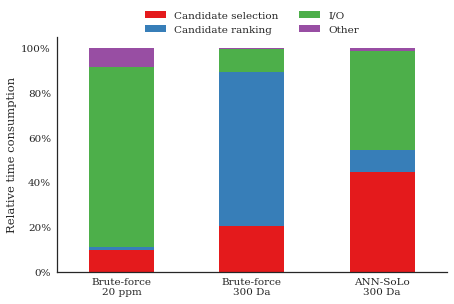

In [7]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

profiling_bar.plot.bar(ax=ax, stacked=True)

ax.set_ylabel('Relative time consumption')

xtick_labels = (profiling['mode'].map(str) + '\n' +
                profiling['precursor_tol_mass'].map(str) + ' ' +
                profiling['precursor_tol_mode'].map(str))
ax.set_xticklabels(xtick_labels, rotation='horizontal')

ax.yaxis.set_major_formatter(mticker.PercentFormatter())

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

sns.despine()

plt.savefig('profiling.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()